# Project 3 - Project 3: Web APIs & Classification

#### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import math as math
import seaborn as sns
import regex as re

from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                              precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


from bs4 import BeautifulSoup   

from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

sns.set_style("darkgrid")

#### Load .csv File (Liverpool FC vs NBA Redit subreddit chats)

In [3]:
posts = pd.read_csv('./datasets/posts_MUFC_NBA_V2.csv')

In [4]:
posts.dtypes

subreddit    object
message      object
dtype: object

In [5]:
posts.groupby('subreddit').count()

,message
subreddit,
liverpool,768
nba,753


In [6]:
posts['subreddit'] = posts['subreddit'].map({'liverpool': 0, 'nba': 1})
posts.head()

,subreddit,message
0,1,draymond green is one tech away from being sus...
1,0,sunderland-born hero jordan henderson in line ...
2,1,a reminder that last summer the warriors didn ...
3,0,a small personal anecdote on why i ll never fo...
4,0,lovren making sure hendo get credit after the ...


In [7]:
posts.groupby('subreddit').count()

,message
subreddit,
0,768
1,753


##### Cleaning Input

In [8]:
message = 'message'

posts[message] = posts[message].str.replace(r"http\S+", "")
posts[message] = posts[message].str.replace(r"http", "")
posts[message] = posts[message].str.replace(r"@\S+", "")
posts[message] = posts[message].str.replace(r"@", "at")
posts[message] = posts[message].str.lower().str.strip()
posts = posts.dropna()

posts.head()

,subreddit,message
0,1,draymond green is one tech away from being sus...
1,0,sunderland-born hero jordan henderson in line ...
2,1,a reminder that last summer the warriors didn ...
3,0,a small personal anecdote on why i ll never fo...
4,0,lovren making sure hendo get credit after the ...


##### Ensure download of Stop Words

In [9]:
# Download text data sets, including stop words. Uncomment this if you did not download!
#nltk.download()  
    
#print(stopwords.words("english"))

##### Consolidated Cleaning function

In [10]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

In [11]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    result_1 = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    result_2 = re.sub("[^a-zA-Z]", " ", result_1)
    
    # 3. Convert to lower case, split into individual words.
    result_3 = tokenizer.tokenize(result_2.lower())
    
    #4. Lemmatize result
    result_4 = [lemmatizer.lemmatize(i) for i in result_3]
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    result_5 = [w for w in result_4 if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(result_5))

In [12]:
# Get the number of reviews based on the dataframe size.
total_reviews = posts.shape[0]
print(f'There are {total_reviews} messages to clean.')

# Initialize an empty list to hold the clean messages.
clean_total_reviews = []


There are 1521 messages to clean.


In [13]:
print("Cleaning and parsing the input...")

total_reviews_no = posts.shape[0]

j = 0
for total_reviews in posts['message']:
    # Convert review to words, then append to clean_train_reviews.
    clean_total_reviews.append(review_to_words(total_reviews))
    
    # If the index is divisible by 500, print a message
    if (j + 1) % 500 == 0:
        print(f'Message {j + 1} of {total_reviews_no}.')
    
    j += 1


Cleaning and parsing the input...
Message 500 of 1521.
Message 1000 of 1521.
Message 1500 of 1521.


In [14]:
clean_total_reviews

['draymond green one tech away suspended nba playoff',
 'sunderland born hero jordan henderson line freedom city liverpool champion league glory',
 'reminder last summer warrior want pay long time head performance therapist chelsea lane',
 'small personal anecdote never forget daniel sturridge',
 'lovren making sure hendo get credit final whistle inside madrid video',
 'durant finish playoff run averaging ppg split reggie miller ha ever higher averaging ppg',
 'request local paper',
 'stein team usa coach gregg popovich also confirmed rely jeff van gundy scouting qb van gundy secured qualification roster mostly made player going use like bar soap pop said jvg',
 'great bit bring noise book klopp life career',
 'durant starting game according sport illistrated',
 'trent',
 'rovell tonight game toronto highest grossing nba game history besting game final cavs warrior average sold price per ticket buyer state amp country',
 'klay thompson everything great always come end whether tomorrow 

##### Train_Test_Split

In [15]:
# Create train_test_split.
#X_train, X_test, y_train, y_test = train_test_split(clean_total_reviews[['message']],
X_train, X_test, y_train, y_test = train_test_split(clean_total_reviews,
                                                    posts['subreddit'],
                                                    shuffle= True,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [16]:
# Find our training size
training_size = int(posts.shape[0] * .7)

# Randomly sample our training data
tweets_train = posts.sample(n=training_size, replace=True)

# Capture the rest of the dataset that's not "training" using an inverse mask (rows NOT IN training dataframe)
mask = posts.index.isin(tweets_train.index)
tweets_test = posts[~mask]

# Should be (2762, 1963) = training / testing = 70/30
tweets_train.shape[0], tweets_test.shape[0]

(1064, 762)

In [17]:
# type(X_train)
pd.DataFrame(X_train)

,0
0,liverpool current transfer window plan michael...
1,bull disliked
2,took kid fate today wa choir lady run husband ...
3,lowry hate right
4,draymond green technical limit
5,toronto win kawhi primed become first player w...
6,warrior grand total two player shooting three ...
7,year one champion league trophy later get fuck...
8,klay get foul call clearly getting hit lowry
9,attached new melwood


In [18]:
pd.DataFrame(X_test)

,0
0,secret agent salah
1,majority liverpool squad back melwood july cau...
2,studge goal
3,rgen klopp decline offer appear graham norton ...
4,champion league trophy celebration x titanic cut
5,liverpool wa car update updated
6,serious concerning fan happens one disrupts ga...
7,top nba final moment jordan flu game final
8,sky sport claim liverpool transfer move spur m...
9,football life lfc


In [19]:
pd.DataFrame(y_train)

,subreddit
292,0
561,1
743,0
526,1
355,1
1237,1
170,1
862,0
636,1
1399,0


In [20]:
type(y_test)

pandas.core.series.Series

In [21]:
pd.DataFrame(y_test)

,subreddit
566,0
1101,0
1473,0
1177,0
1009,0
433,0
855,1
1491,1
1032,0
1079,0


## Pipeline for CountVectorizer and Logistic Regression

Our pipeline will consist to two stages:
1. An instance of `CountVectorizer`
2. A `LogisticRegression` instance

In [22]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [23]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
     'cvec__min_df': [2,3],
     'cvec__max_df': [.9,.99],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

C:\Users\FCG\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9201127819548872


{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [24]:
gs.predict(X_test)

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,

In [25]:
gs.score(X_test,y_test)

0.9409190371991247

## Pipeline for CountVectorizer, TfidfTransformer and MultinomialNB

Our pipeline will consist to two stages:
1. An instance of `CountVectorizer`
2. A `TfidfTransformer` instance
3. A `MultinomialNB` instance

In [26]:
# MultinomialNB
pipeline = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnnb', MultinomialNB())
]) 

In [27]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
     'cvec__min_df': [2,3],
     'cvec__max_df': [.9,.99],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_


C:\Users\FCG\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9201127819548872


{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [28]:
gs.score(X_test,y_test)

0.9409190371991247

# Pipeline for CountVectorizer, TfidfTransformer and BernoulliNB

Our pipeline will consist to two stages:
1. An instance of `CountVectorizer`
2. A `TfidfTransformer` instance
3. A `BernoulliNB` instance

In [29]:
# BernoulliNB
pipeline = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('bnb', BernoulliNB())
]) 


In [30]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
     'cvec__min_df': [2,3],
     'cvec__max_df': [.9,.99],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_


C:\Users\FCG\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9201127819548872


{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [31]:
gs.predict(X_test)

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,

In [32]:
gs.score(X_test,y_test)

0.9409190371991247

### Sentiment Analysis

In [33]:
# create empty data frame in pandas
clean_data = pd.DataFrame()
clean_data['subreddit']  = posts['subreddit']
clean_data['message'] = clean_total_reviews

In [34]:
clean_data['subreddit'].count()

1521

In [35]:
clean_data['subreddit'].value_counts()/ clean_data['subreddit'].count()

0    0.504931
1    0.495069
Name: subreddit, dtype: float64

In [36]:
y = clean_data['subreddit']
X = clean_data[['message']]

In [37]:
# Log reg as baseline
# CountVectorizer need input as String
logreg_pipe = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('log_reg_clf', LogisticRegression()),
                        ])
logreg_pipe.fit(X_train, y_train)
y_pred = logreg_pipe.predict(X_test)
#print(y_pred)
print('Logistic Regression accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Logistic Regression accuracy 0.9431072210065645
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       229
           1       0.96      0.92      0.94       228

   micro avg       0.94      0.94      0.94       457
   macro avg       0.94      0.94      0.94       457
weighted avg       0.94      0.94      0.94       457



### Wordcloud visualization for Liverpool FC messages

In [38]:
# wordcloud_text_tifu = " ".join(combine_clean[combine_clean['subreddit'] == "tifu"]["gd_lem_words"])
# wordcloud_text_fps = " ".join(combine_clean[combine_clean['subreddit'] == "fatpeoplestories"]["gd_lem_words"])

text_lpfc = " ".join(clean_data[clean_data['subreddit'] == 0]["message"])
text_nba = " ".join(clean_data[clean_data['subreddit'] == 1]["message"])


In [39]:
# Generate a word cloud image
stops = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stops, background_color="white").generate(text_lpfc)

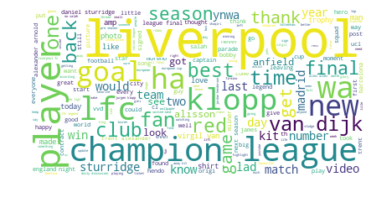

In [40]:
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Wordcloud visualization for NBA messages

In [41]:
# Start with one review:
text = clean_data.message[1]
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

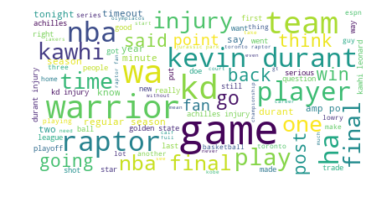

In [42]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white").generate(text_nba)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()